# 必要なパッケージを読み込む

In [1]:
# 色々メッセージが出てくるけど気にしない
library(scater)
library(tidyverse)
library(cowplot)
library(dbscan)
library(gplots)
library(viridis)
library(scran)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [2]:
# t-SNEなどランダムな初期化を用いるものについて、再現性を確保するためにシードを固定する
set.seed(1234)

# データを読み込む

In [3]:
counts = read_tsv("GSM3173562_Lakshmipuram_NCBI_processeddata.txt", col_names=TRUE)

Parsed with column specification:
cols(
  .default = col_double(),
  GENE = col_character()
)

See spec(...) for full column specifications.



In [4]:
# 中身の確認
counts

GENE,TAAGTTTGCAAT,CGCGACAGACTA,CCGATCCAGCCT,AATGGTATCCCT,TAAGTCACATCC,AACGACAACAGT,GCTCTTCTAAGA,ACGGCTTTTTAG,ACACCGGGCCGC,...,CTACTCAGAAAA,CAGTACGTAATA,GCTAAGCGATAA,ATGATAATGAAA,GACCATCGCCAA,TGAGTGCGCGGA,AGTTGCTCCCAA,AAATACGTATGG,CAAGGGTGCCGA,GGTGTGGATAGG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BPKG21685,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bmi-1[1]_SmedASXL_000659,1,0,0,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCD-like_smed016097,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H.1.3b_spondin_SmedASXL_017661,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LGR4_SmedASXL_005791,0,1,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
LGR4l_SmedASXL_014091,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Smed-APC_smed014505_SmedASXL_000490_SmedASXL_002637,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Smed-Bcat-1_SmedASXL_006667,0,0,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Smed-COE_SmedASXL_000653,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# データフレームを行列に変換する
counts %>% 
select(-GENE) %>% 
as.matrix() ->
counts_matrix

rownames(counts_matrix) <- counts$GENE

In [6]:
# データオブジェクトの構造を確認
str(counts_matrix)

 num [1:51562, 1:2000] 0 1 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:51562] "BPKG21685" "Bmi-1[1]_SmedASXL_000659" "CCD-like_smed016097" "H.1.3b_spondin_SmedASXL_017661" ...
  ..$ : chr [1:2000] "TAAGTTTGCAAT" "CGCGACAGACTA" "CCGATCCAGCCT" "AATGGTATCCCT" ...


In [7]:
# SingleCellExperiment オブジェクトを作る (遺伝子発現量の行列と細胞側・遺伝子側のメタデータをまとめたデータオブジェクト)
# (sce は行が遺伝子、列が細胞である)

SingleCellExperiment(
    assays = list(counts = counts_matrix)
) -> 
sce

In [8]:
# 中身の確認
sce

class: SingleCellExperiment 
dim: 51562 2000 
metadata(0):
assays(1): counts
rownames(51562): BPKG21685 Bmi-1[1]_SmedASXL_000659 ...
  spondin_smed012475 spondin_smed016197
rowData names(0):
colnames(2000): TAAGTTTGCAAT CGCGACAGACTA ... CAAGGGTGCCGA GGTGTGGATAGG
colData names(0):
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [9]:
sce %>% perCellQCMetrics -> colData(sce)

In [10]:
sce %>% perFeatureQCMetrics -> rowData(sce)

In [11]:
sce

class: SingleCellExperiment 
dim: 51562 2000 
metadata(0):
assays(1): counts
rownames(51562): BPKG21685 Bmi-1[1]_SmedASXL_000659 ...
  spondin_smed012475 spondin_smed016197
rowData names(2): mean detected
colnames: NULL
colData names(7): sum detected ... percent_top_500 total
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [12]:
colData(sce)

# `total` (リードカウント数の細胞ごとの合計) はある細胞のデータの品質を調べるのに便利な指標です。

DataFrame with 2000 rows and 7 columns
           sum  detected   percent_top_50  percent_top_100  percent_top_200
     <numeric> <integer>        <numeric>        <numeric>        <numeric>
1        20785      4132 55.1166706759683  60.490738513351 66.0331970170796
2        25176      4522 46.8660629170639 52.4388306323483 58.7940896091516
3        15478      4234 38.8293061119008  44.682775552397 51.8994702157902
4        22114      4251 46.8074522926653 54.9832685176811 63.0867323867233
5        17044      4466 34.3992020652429 40.8237502933584 48.6974888523821
...        ...       ...              ...              ...              ...
1996       153        93 71.8954248366013              100              100
1997       192       116           65.625 91.6666666666667              100
1998       232       116  71.551724137931 93.1034482758621              100
1999       224       116 70.5357142857143 92.8571428571429              100
2000       267       167 56.1797752808989 74.9063

## 細胞のフィルタリングをする

リードカウントが多いまたは少ない細胞は品質がよくないと考え、解析から除く。

In [13]:
sce %>% {colData(.)$total} %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     295     699    1705    2111   25176 

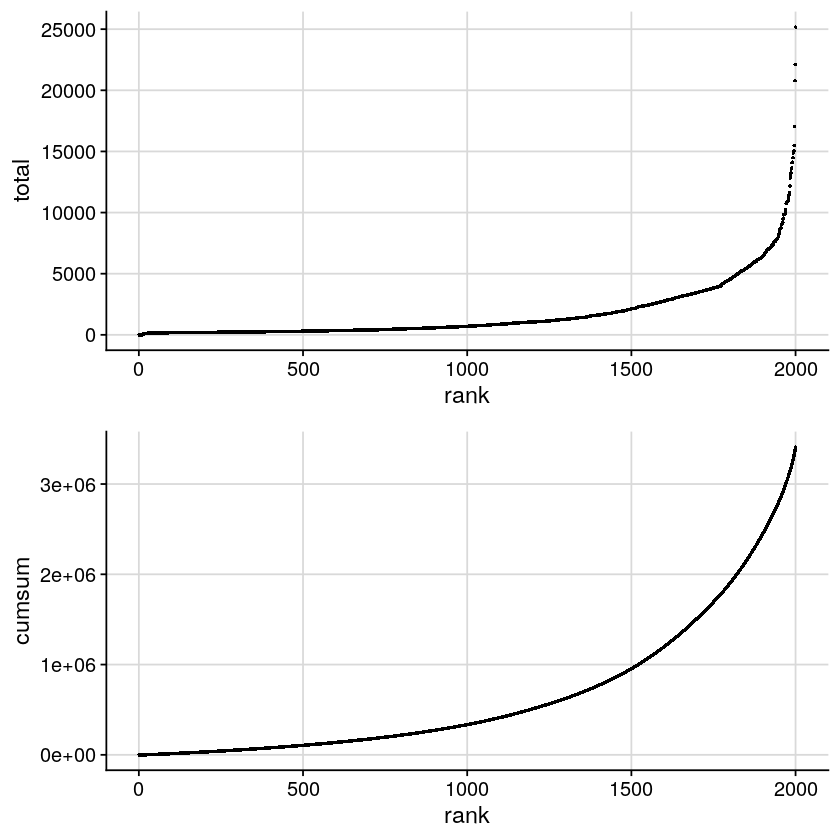

In [14]:
sce %>% 
colData %>% 
as_tibble %>%
arrange(total) %>%
mutate(rank = 1:n(), cumsum = cumsum(total)) %>%
{
    p1 <- ggplot(. , aes(x = rank, y = total)) +
        geom_point(size = 1, stroke = 0) +
        theme_half_open() + 
        background_grid()

    p2 <- ggplot(., aes( x =rank, y = cumsum)) +
        geom_point(size = 1, stroke = 0) +
        theme_half_open() + 
        background_grid()        

    plot_grid(p1, p2, ncol = 1, align = "v")
}

In [15]:
# totalが少ない方から1000番目の細胞のtotalを細胞を除去する下限値とする
sce %>% 
colData %>%
.$total %>%
sort %>% 
.[1000] -> 
count_cutoff_low

count_cutoff_high <- 13000

In [16]:
# 細胞のフィルタリングをする
sce %>%
.[, between(colData(.)$total, count_cutoff_low, count_cutoff_high)] -> 
sce

In [17]:
# 残った細胞の合計カウント (total) の分布を確認する
sce %>% 
colData %>% 
.$total %>%
summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    699    1125    2066    2863    3731   12834 

In [18]:
sce

class: SingleCellExperiment 
dim: 51562 985 
metadata(0):
assays(1): counts
rownames(51562): BPKG21685 Bmi-1[1]_SmedASXL_000659 ...
  spondin_smed012475 spondin_smed016197
rowData names(2): mean detected
colnames: NULL
colData names(7): sum detected ... percent_top_500 total
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

## 遺伝子のフィルタリングをする

発現量が低い遺伝子や一部の細胞でしか出ていない遺伝子はノイジーと考えて除く

In [19]:
# 発現量平均値 (mean) と検出された細胞割合 (detected) が低い遺伝子は除く
sce %>% 
{ .[(rowData(.)$mean >= 0.01) & (rowData(.)$detected  >= 0.01)] } ->
sce

In [20]:
# 中身の確認
sce

class: SingleCellExperiment 
dim: 11489 985 
metadata(0):
assays(1): counts
rownames(11489): Bmi-1[1]_SmedASXL_000659 CCD-like_smed016097 ...
  spondin_smed009579 spondin_smed012475
rowData names(2): mean detected
colnames: NULL
colData names(7): sum detected ... percent_top_500 total
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

## PCAを用いて次元削減を行う

PCA（主成分分析）は、高次元のデータを低次元の空間に情報の欠損を最小限に抑えて射影する手法である。ここでは、高次元のデータのノイズを低減する目的で使う。

In [21]:
sce %>% 
{sizeFactors(.) <- librarySizeFactors(.); .} %>%
logNormCounts ->
sce

In [22]:
# `assay` に `logcounts` が増えていることを確認する
sce

class: SingleCellExperiment 
dim: 11489 985 
metadata(0):
assays(2): counts logcounts
rownames(11489): Bmi-1[1]_SmedASXL_000659 CCD-like_smed016097 ...
  spondin_smed009579 spondin_smed012475
rowData names(2): mean detected
colnames: NULL
colData names(7): sum detected ... percent_top_500 total
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [23]:
# 発現量の対数返還後の分散が大きい方から500個の遺伝子のみでPCAを行う。保存する主成分の数は30に設定した。

sce %>%
runPCA(ntop = 500, ncomponents = 30) ->
sce

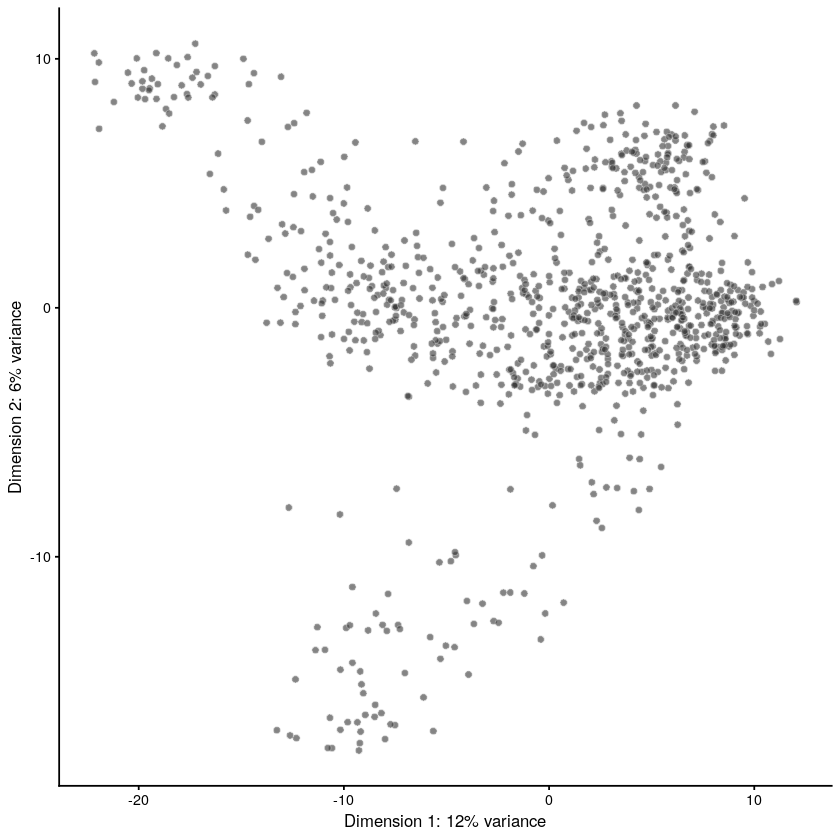

In [24]:
sce %>%
plotReducedDim(dimred = "PCA")

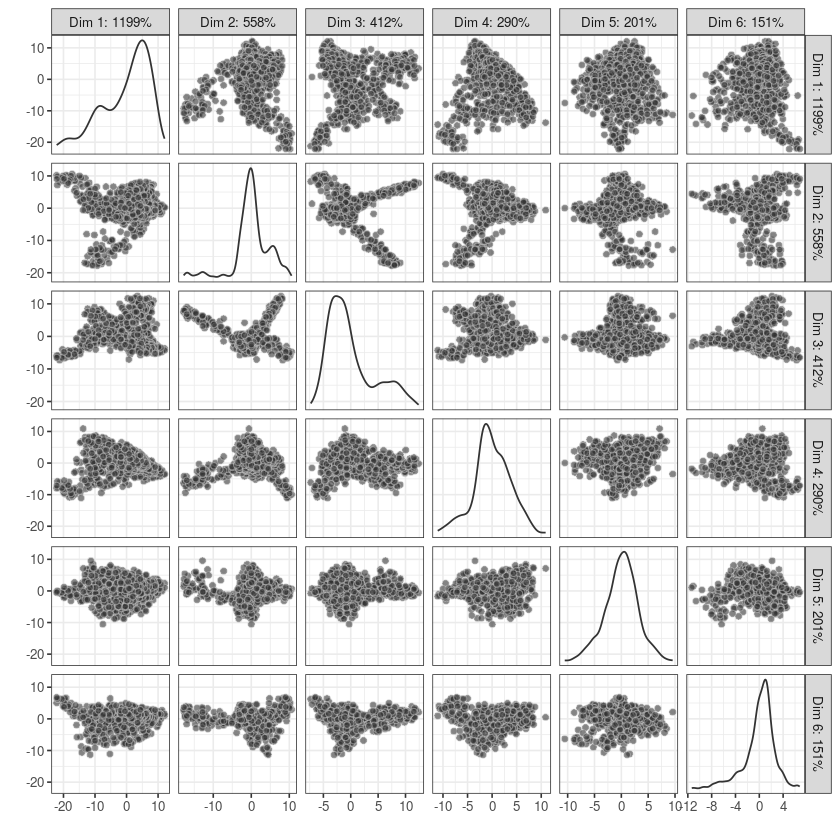

In [25]:
sce %>%
plotReducedDim(dimred = "PCA", ncomponent = 6)

## PCAの結果をさらにUMAPにかける

UMAPという非線形な次元圧縮法を用いて、PCAでの30次元の結果をさらに２次元に写像する。

In [26]:
sce %>%
runUMAP(dimred = "PCA") ->
sce

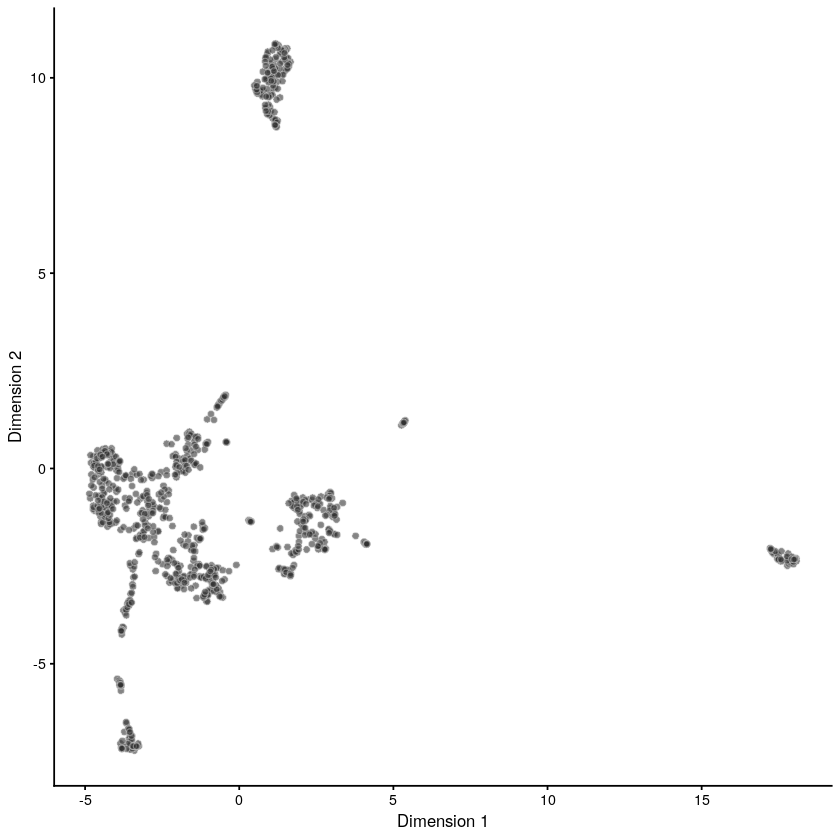

In [27]:
sce %>%
plotReducedDim(dimred = "UMAP")

# クラスタリングをする

UMAPの結果に基づき、細胞をクラスリングする。

In [28]:
sce %>%
runUMAP(dimred = "PCA", ncomponents = 8, n_neighbors = 30, min_dist = 0) %>%
{reducedDims(.)$UMAP} %>%
hdbscan(minPts = 5) %>%
.$cluster %>%
as_factor -> 
colData(sce)$hdbscan

In [29]:
# 各クラスターのサイズ（クラスターに含まれる細胞数）を調べる。ただし、 0番はいずれのクラスターにも属さない細胞の数
table(colData(sce)$hdbscan)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
183  55 146  14  18  15   8  13  25   5  12  20  10  46  20  29   5   8   7  57 
 20  21  22  23  24  25  26  27  28 
 36  11   7  66   5   9  41  56  58 

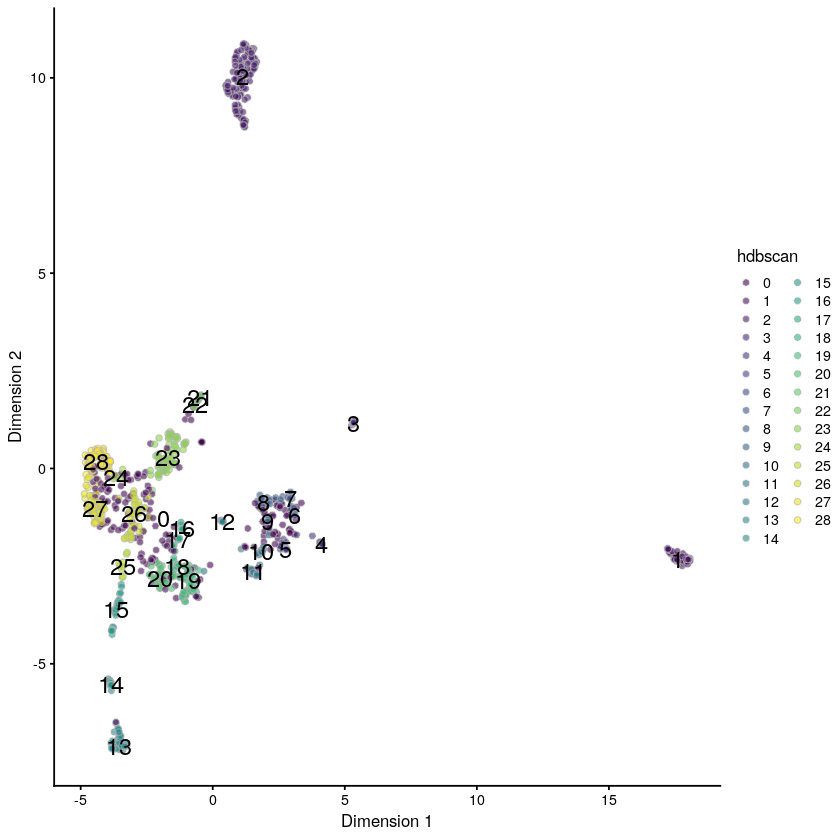

In [30]:
# 各クラスターの重心にクラスター番号を表示する
sce %>%
plotReducedDim(dimred = "UMAP", colour_by = "hdbscan", text_by = "hdbscan")

## クラスター同士の関係を調べる

In [31]:
# 分散が大きい遺伝子を300個とる
sce %>%
logcounts %>%
as.matrix %>%
rowVars %>%
order(decreasing = TRUE) %>%
head(300) -> 
variable_genes

In [32]:
# 各クラスターについて、遺伝子の平均発現量を計算する
sce[variable_genes,] %>%
logcounts %>%
t %>%
as.matrix %>%
as_tibble %>%
split(colData(sce)$hdbscan) %>%
map(colMeans) %>%
bind_cols ->
cluster_means 

In [33]:
head(cluster_means)

0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.6201981,6.2521289,1.9014072,2.2508190,7.0613263,1.7178185,2.14061020,2.2280742,1.8626267,2.0978590,...,2.0512146,2.4015764,2.90028136,3.0615406,5.5325439,1.5882095,2.2456946,1.6006428,2.3157950,2.2234678
0.6715027,0.3221516,4.6617039,0.3653030,0.8797670,0.6826181,0.59537589,0.3090603,0.7732974,0.9389669,...,0.5262723,0.6458689,0.38735896,0.5084133,0.5403934,0.4135459,0.5090812,0.6077546,0.4913585,0.5234904
0.4892077,6.2978878,0.2552964,0.3617220,0.4434907,0.3711199,0.19768485,0.7193695,0.3950171,0.5850955,...,0.3444476,0.3905879,0.08059445,0.6702343,0.3566401,0.3020403,0.4806403,0.1167684,0.3602047,0.4345891
0.7702150,0.6020283,4.3578162,1.1799140,0.2823879,0.4932514,1.05570028,0.5218610,0.9908439,0.9346211,...,0.7577142,0.6044392,0.56077039,0.8424152,0.5896370,0.5323772,0.6423692,0.3292362,0.5844467,0.6109981
1.2625179,0.2544806,0.3439068,0.3445986,0.2725337,0.4939983,0.73834186,0.4220736,0.6712894,0.4876616,...,2.4610390,2.6312378,4.40694577,3.9454964,0.9092126,1.6309418,3.4117660,1.5826633,1.5676241,1.4018781
1.2256200,0.3571903,0.2599568,0.2890748,0.3098867,0.2341989,0.06342514,0.2102516,0.5127948,0.5212898,...,2.3563329,2.6128910,4.20442194,3.7637144,0.9089606,1.4608113,3.3660317,1.3792511,1.5302271,1.3020791


In [34]:
sce[variable_genes,] %>% 
rownames -> 
rownames(cluster_means)

Warning message:
"Setting row names on a tibble is deprecated."


In [35]:
sce

class: SingleCellExperiment 
dim: 11489 985 
metadata(0):
assays(2): counts logcounts
rownames(11489): Bmi-1[1]_SmedASXL_000659 CCD-like_smed016097 ...
  spondin_smed009579 spondin_smed012475
rowData names(2): mean detected
colnames: NULL
colData names(8): sum detected ... total hdbscan
reducedDimNames(2): PCA UMAP
spikeNames(0):
altExpNames(0):

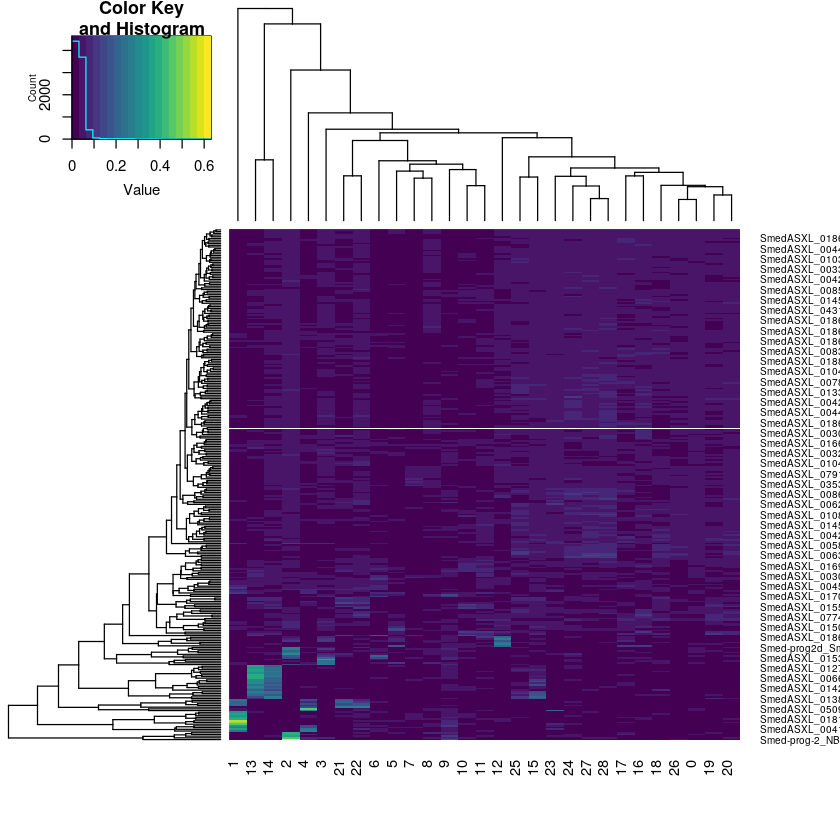

In [36]:
# ヒートマップで、クラスター間の関係を眺める
cluster_means %>%
as.matrix %>%
{. / rowSums(.)} %>%
{rownames(.) <- rownames(sce[variable_genes,]); .} %>%  # add gene names
heatmap.2(col = viridis(20), trace = "none")

## 遺伝子発現量をUMAPの図に重ねる

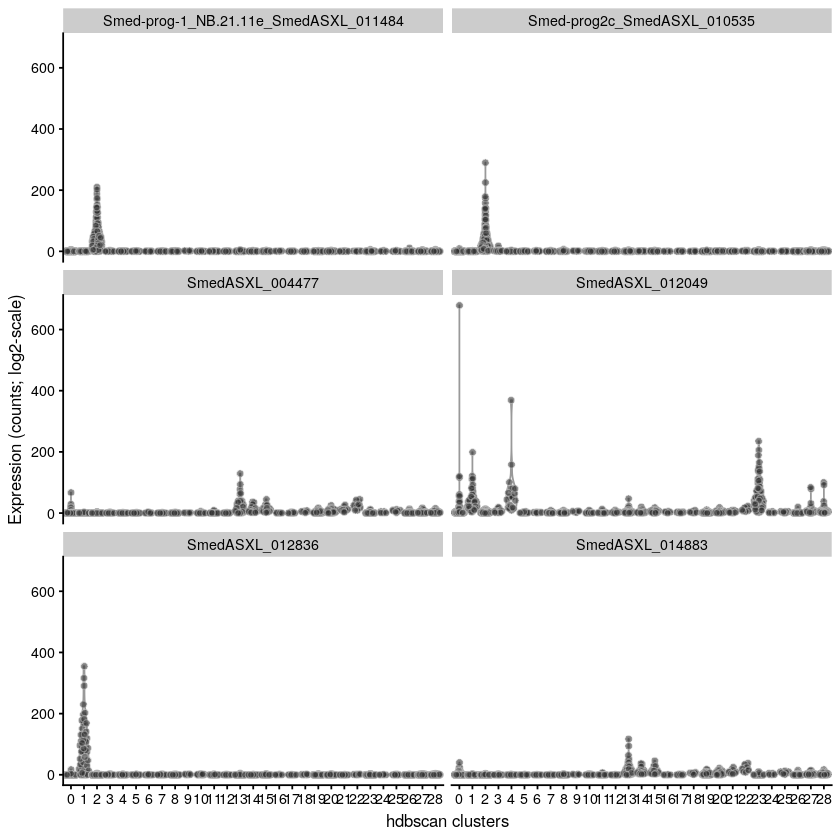

In [37]:
# クラスターごとの発現量をプロットする
plotExpression(sce, rownames(sce)[ variable_genes[1:6] ],
    x = "hdbscan", exprs_values = "counts", 
     show_median = TRUE, 
    xlab = "hdbscan clusters", log = TRUE)

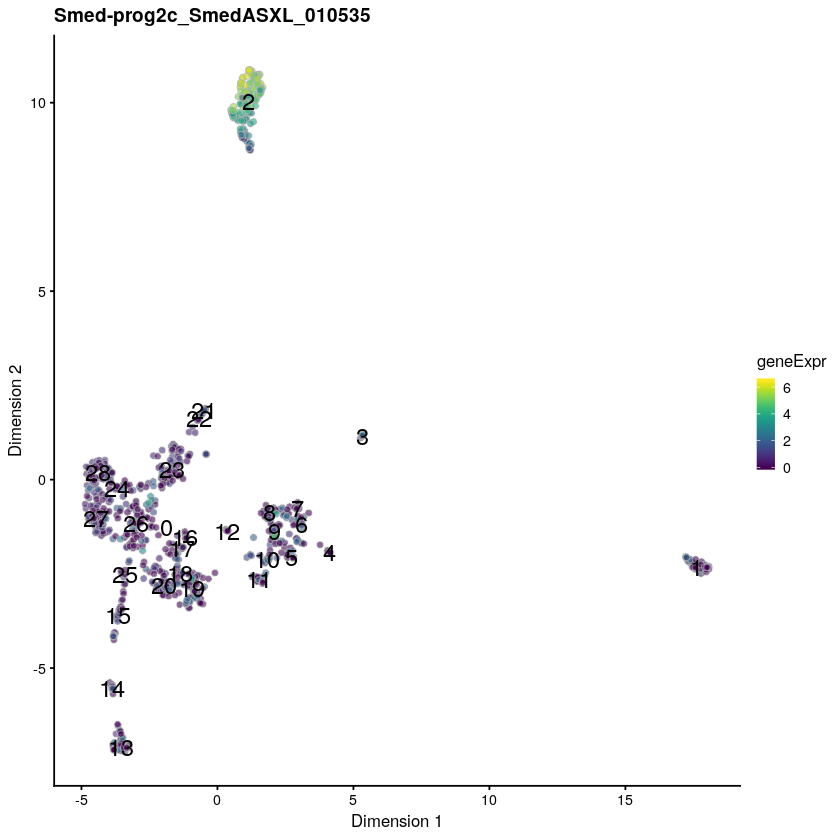

In [38]:
# 試しに variable_genes の 4番目の遺伝子の発現量をUMAPの図に色の違いとして表示する

sce %>% 
{colData(.)$geneExpr <- logcounts(.)[variable_genes[4],]; .} %>%
plotReducedDim(dimred = "UMAP", colour_by = "geneExpr", text_by = "hdbscan") + ggtitle(rownames(sce)[variable_genes[4]])

# 遺伝子ごとの分散を考慮して高変動遺伝子を選び、PCAをし直す

[1] 1494

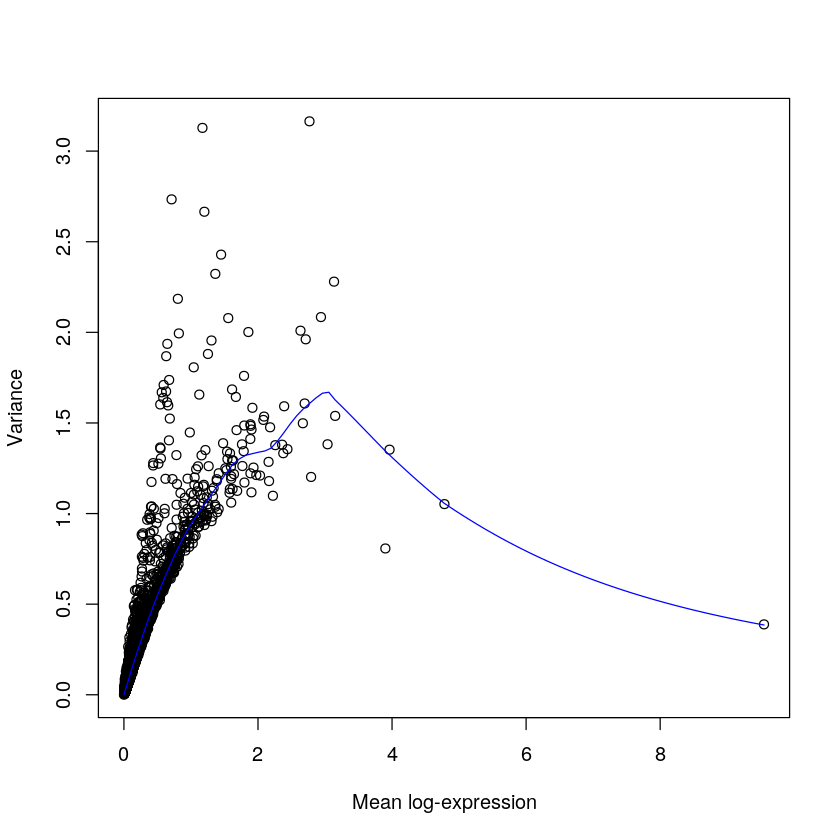

In [39]:
dec <- modelGeneVar(sce)
plot(dec$mean, dec$total, xlab="Mean log-expression", ylab="Variance")
curve(metadata(dec)$trend(x), col="blue", add=TRUE)
top_hvgs <- getTopHVGs(dec,  fdr.threshold=0.05)
length(top_hvgs)

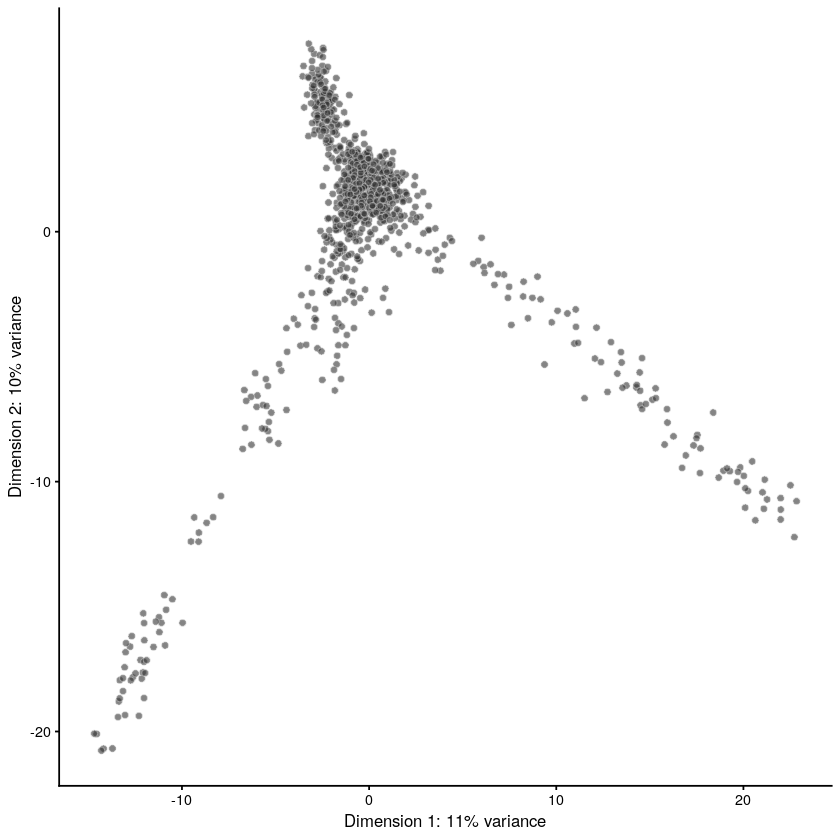

In [40]:
sce %>%
runPCA(ncomponents = 30, subset_row=top_hvgs, name="PCA_top_hvgs") ->
sce

sce %>%
plotReducedDim(dimred = "PCA_top_hvgs")

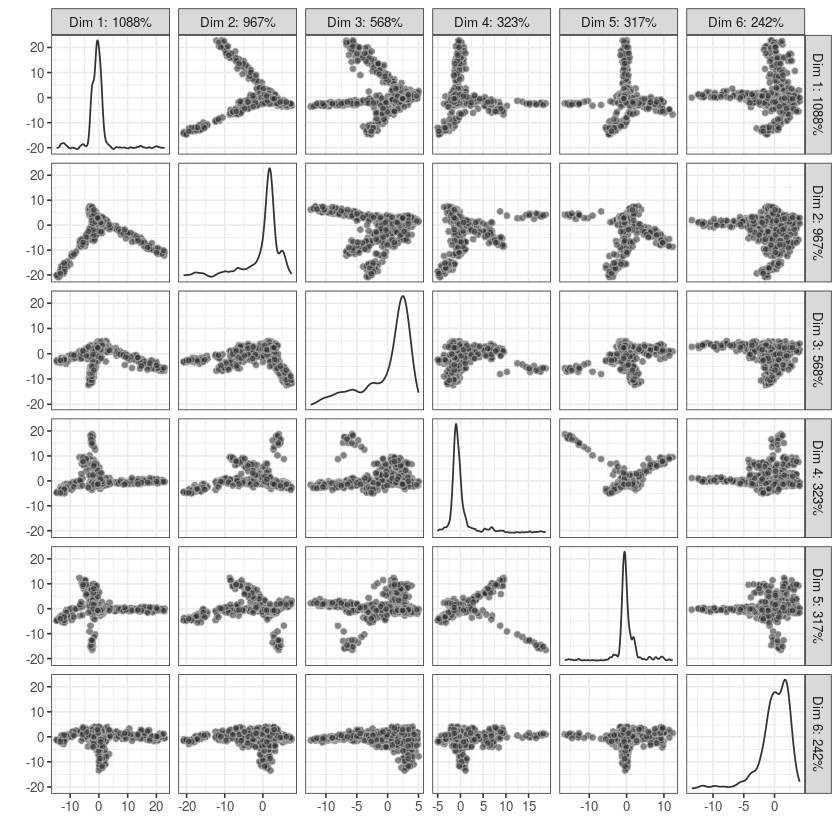

In [41]:
sce %>%
plotReducedDim(dimred = "PCA_top_hvgs", ncomponents = 6)

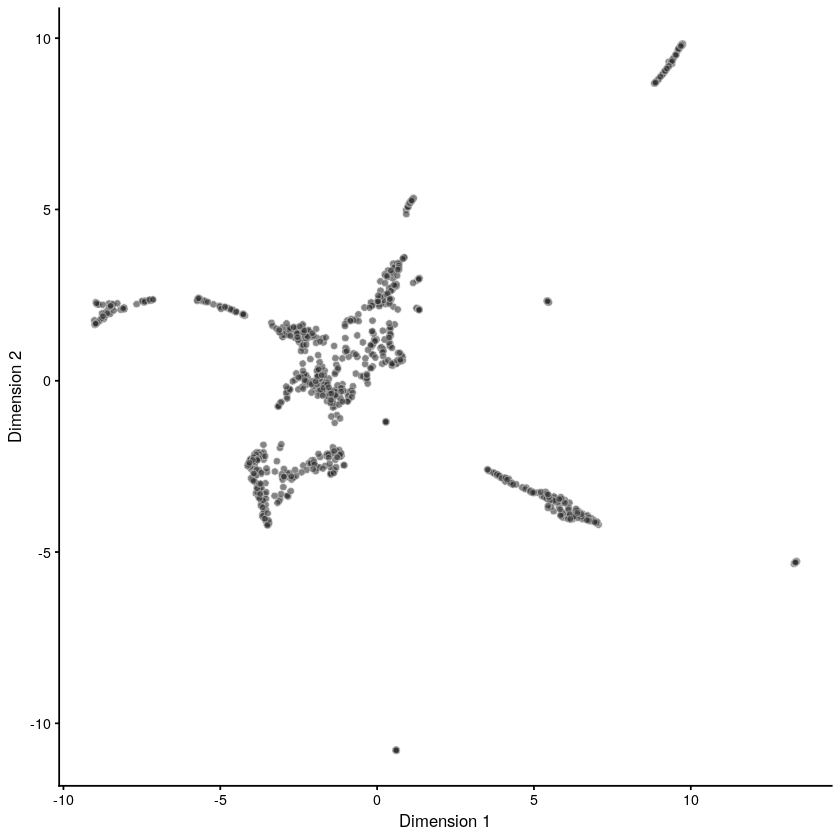

In [42]:
sce %>%
runUMAP(dimred = "PCA_top_hvgs", name="UMAP_top_hvgs") ->
sce

sce %>%
plotReducedDim(dimred = "UMAP_top_hvgs")


## 各クラスターに特徴的な遺伝子を探す

In [43]:
markers <- findMarkers(sce, colData(sce)$hdbscan)

In [44]:
markers[[1]][,1:3]

DataFrame with 11489 rows and 3 columns
                                  Top              p.value                  FDR
                            <integer>            <numeric>            <numeric>
Smed-prog2c_SmedASXL_010535         1 2.48597536461288e-71 2.85613709640377e-67
SmedASXL_002004                     1 6.32501481740091e-11 1.50140692638676e-09
SmedASXL_003345                     1 9.60120249538776e-48 9.19235128912579e-45
SmedASXL_003717                     1  7.5842255811876e-19 4.98777734319762e-17
SmedASXL_004477                     1 2.36566646920586e-22 2.56407000610435e-20
...                               ...                  ...                  ...
SmedASXL_078114                  5841    0.446116670643157    0.451321650480266
SmedASXL_019175                  5982                    1                    1
SmedASXL_019433                  6000                    1                    1
SmedASXL_017699                  6044    0.495661975238267    0.500109284736855


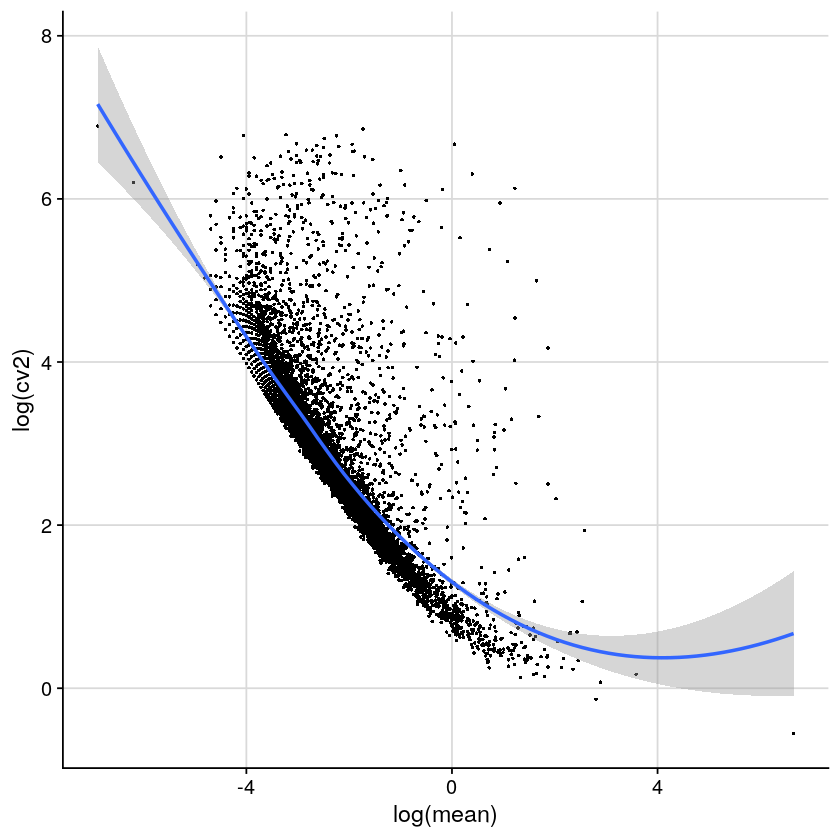

In [45]:
sce %>%
counts %>%
as.matrix %>%
{tibble(mean = rowMeans(.), cv2 = rowVars(.)/rowMeans(.)^2)} %>%
ggplot(aes(log(mean), log(cv2))) + 
     geom_point(size = 1, stroke = 0) +
     geom_smooth(method="loess") +
     theme_half_open() + 
     background_grid()

# 発展課題

以下のコマンドを**ターミナルで打つ**と、ヒトとプラナリアのオーソログ関係の表（一部）がダウンロードできる

```
$ wget https://raw.githubusercontent.com/bioinfo-tsukuba/20201226-EB62104-bioinformatics-course/master/human_ortholog_subset.tsv
```

各クラスターに特徴的な遺伝子から、各クラスターの細胞の機能を類推せよ

joinを使うとよい

In [47]:
human_ortholog = read_tsv("human_ortholog_subset.tsv", col_names=TRUE)

Parsed with column specification:
cols(
  Smed_Code = col_character(),
  `Gene stable ID` = col_character(),
  `Gene description` = col_character(),
  `Transcript stable ID` = col_character(),
  `Protein stable ID` = col_character(),
  `Gene name` = col_character(),
  `HGNC symbol` = col_character(),
  `UniProtKB/Swiss-Prot ID` = col_character()
)



In [49]:
str(human_ortholog)

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	5683 obs. of  8 variables:
 $ Smed_Code              : chr  "SmedASXL_014454" "SmedASXL_018345" "SmedASXL_018456" "SmedASXL_014192" ...
 $ Gene stable ID         : chr  "ENSG00000197102" "ENSG00000039139" "ENSG00000187775" "ENSG00000114841" ...
 $ Gene description       : chr  "dynein cytoplasmic 1 heavy chain 1 [Source:HGNC Symbol;Acc:HGNC:2961]" "dynein axonemal heavy chain 5 [Source:HGNC Symbol;Acc:HGNC:2950]" "dynein axonemal heavy chain 17 [Source:HGNC Symbol;Acc:HGNC:2946]" "dynein axonemal heavy chain 1 [Source:HGNC Symbol;Acc:HGNC:2940]" ...
 $ Transcript stable ID   : chr  "ENST00000360184" "ENST00000265104" "ENST00000591369" "ENST00000420323" ...
 $ Protein stable ID      : chr  "ENSP00000348965" "ENSP00000265104" "ENSP00000466150" "ENSP00000401514" ...
 $ Gene name              : chr  "DYNC1H1" "DNAH5" "DNAH17" "DNAH1" ...
 $ HGNC symbol            : chr  "DYNC1H1" "DNAH5" "DNAH17" "DNAH1" ...
 $ UniProtKB/Swiss-Prot I

In [50]:
markers[[1]][,1:3] %>%
as_tibble %>% 
mutate(gene_name = rownames(markers[[1]][,1:3])) %>%
filter(FDR < 0.05) %>%
inner_join(human_ortholog, by=c("gene_name" = "Smed_Code")) 

Top,p.value,FDR,gene_name,Gene stable ID,Gene description,Transcript stable ID,Protein stable ID,Gene name,HGNC symbol,UniProtKB/Swiss-Prot ID
<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,7.584226e-19,4.987777e-17,SmedASXL_003717,ENSG00000115514,thioredoxin domain containing 9 [Source:HGNC Symbol;Acc:HGNC:24110],ENST00000264255,ENSP00000264255,TXNDC9,TXNDC9,O14530
1,3.749490e-18,2.316015e-16,SmedASXL_005331,ENSG00000179041,ribosome biogenesis regulator homolog [Source:HGNC Symbol;Acc:HGNC:17083],ENST00000320270,ENSP00000322396,RRS1,RRS1,Q15050
1,4.496819e-24,6.224573e-22,SmedASXL_006411,ENSG00000135387,cell cycle associated protein 1 [Source:HGNC Symbol;Acc:HGNC:6743],ENST00000341394,ENSP00000340329,CAPRIN1,CAPRIN1,Q14444
1,1.067828e-44,8.763054e-42,SmedASXL_007801,ENSG00000130598,"troponin I2, fast skeletal type [Source:HGNC Symbol;Acc:HGNC:11946]",ENST00000381911,ENSP00000371336,TNNI2,TNNI2,P48788
1,4.008823e-25,6.486953e-23,SmedASXL_008182,ENSG00000144381,heat shock protein family D (Hsp60) member 1 [Source:HGNC Symbol;Acc:HGNC:5261],ENST00000388968,ENSP00000373620,HSPD1,HSPD1,P10809
1,7.591035e-46,6.708723e-43,SmedASXL_012049,ENSG00000075624,actin beta [Source:HGNC Symbol;Acc:HGNC:132],ENST00000331789,ENSP00000349960,ACTB,ACTB,P60709
1,3.789544e-25,6.309865e-23,SmedASXL_018638,ENSG00000133112,"tumor protein, translationally-controlled 1 [Source:HGNC Symbol;Acc:HGNC:12022]",ENST00000530705,ENSP00000431872,TPT1,TPT1,P13693
1,4.965192e-30,1.629860e-27,SmedASXL_018654,ENSG00000233927,ribosomal protein S28 [Source:HGNC Symbol;Acc:HGNC:10418],ENST00000600659,ENSP00000472469,RPS28,RPS28,P62857
1,4.816571e-23,5.825009e-21,SmedASXL_019071,ENSG00000143256,prefoldin subunit 2 [Source:HGNC Symbol;Acc:HGNC:8867],ENST00000368010,ENSP00000356989,PFDN2,PFDN2,Q9UHV9


In [51]:
markers[[2]][,1:3] %>%
as_tibble %>% 
mutate(gene_name = rownames(markers[[2]][,1:3])) %>%
filter(FDR < 0.05) %>%
inner_join(human_ortholog, by=c("gene_name" = "Smed_Code")) 

Top,p.value,FDR,gene_name,Gene stable ID,Gene description,Transcript stable ID,Protein stable ID,Gene name,HGNC symbol,UniProtKB/Swiss-Prot ID
<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,2.069170e-50,2.971587e-47,SmedASXL_007801,ENSG00000130598,"troponin I2, fast skeletal type [Source:HGNC Symbol;Acc:HGNC:11946]",ENST00000381911,ENSP00000371336,TNNI2,TNNI2,P48788
2,6.477107e-47,7.441548e-44,SmedASXL_012049,ENSG00000075624,actin beta [Source:HGNC Symbol;Acc:HGNC:132],ENST00000331789,ENSP00000349960,ACTB,ACTB,P60709
5,1.167288e-17,8.765341e-16,SmedASXL_014095,ENSG00000197746,prosaposin [Source:HGNC Symbol;Acc:HGNC:9498],ENST00000394936,ENSP00000378394,PSAP,PSAP,P07602
6,4.247337e-28,1.134829e-25,SmedASXL_003885,ENSG00000131773,"KH RNA binding domain containing, signal transduction associated 3 [Source:HGNC Symbol;Acc:HGNC:18117]",ENST00000355849,ENSP00000348108,KHDRBS3,KHDRBS3,O75525
7,3.333428e-30,1.094222e-27,SmedASXL_004168,ENSG00000157869,"RAB28, member RAS oncogene family [Source:HGNC Symbol;Acc:HGNC:9768]",ENST00000511649,ENSP00000424899,RAB28,RAB28,NA
7,1.300556e-14,6.854170e-13,SmedASXL_009686,ENSG00000149016,"terminal uridylyl transferase 1, U6 snRNA-specific [Source:HGNC Symbol;Acc:HGNC:26184]",ENST00000476907,ENSP00000419607,TUT1,TUT1,Q9H6E5
8,2.595115e-35,1.419775e-32,SmedASXL_004345,ENSG00000164104,high mobility group box 2 [Source:HGNC Symbol;Acc:HGNC:5000],ENST00000296503,ENSP00000296503,HMGB2,HMGB2,P26583
9,1.202380e-14,6.365967e-13,SmedASXL_006517,ENSG00000109861,cathepsin C [Source:HGNC Symbol;Acc:HGNC:2528],ENST00000227266,ENSP00000227266,CTSC,CTSC,P53634
10,1.826866e-18,1.520932e-16,SmedASXL_003141,ENSG00000100316,ribosomal protein L3 [Source:HGNC Symbol;Acc:HGNC:10332],ENST00000401609,ENSP00000386101,RPL3,RPL3,NA


In [52]:
markers[[3]][,1:3] %>%
as_tibble %>% 
mutate(gene_name = rownames(markers[[3]][,1:3])) %>%
filter(FDR < 0.05) %>%
inner_join(human_ortholog, by=c("gene_name" = "Smed_Code")) 

Top,p.value,FDR,gene_name,Gene stable ID,Gene description,Transcript stable ID,Protein stable ID,Gene name,HGNC symbol,UniProtKB/Swiss-Prot ID
<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,3.908333e-93,4.490284e-89,SmedASXL_002116,ENSG00000100219,X-box binding protein 1 [Source:HGNC Symbol;Acc:HGNC:12801],ENST00000216037,ENSP00000216037,XBP1,XBP1,P17861
2,7.983819e-43,4.367909e-40,SmedASXL_008454,ENSG00000073282,tumor protein p63 [Source:HGNC Symbol;Acc:HGNC:15979],ENST00000264731,ENSP00000264731,TP63,TP63,Q9H3D4
3,5.757057e-30,8.165781e-28,SmedASXL_006411,ENSG00000135387,cell cycle associated protein 1 [Source:HGNC Symbol;Acc:HGNC:6743],ENST00000341394,ENSP00000340329,CAPRIN1,CAPRIN1,Q14444
3,6.932166e-35,1.625381e-32,SmedASXL_012732,ENSG00000044574,heat shock protein family A (Hsp70) member 5 [Source:HGNC Symbol;Acc:HGNC:5238],ENST00000324460,ENSP00000324173,HSPA5,HSPA5,P11021
3,1.217384e-42,6.357510e-40,SmedASXL_018715,ENSG00000115541,heat shock protein family E (Hsp10) member 1 [Source:HGNC Symbol;Acc:HGNC:5269],ENST00000233893,ENSP00000233893,HSPE1,HSPE1,P61604
4,2.676153e-49,2.562193e-46,SmedASXL_004223,ENSG00000105640,ribosomal protein L18a [Source:HGNC Symbol;Acc:HGNC:10311],ENST00000222247,ENSP00000222247,RPL18A,RPL18A,Q02543
4,4.659940e-12,8.677157e-11,SmedASXL_009934,ENSG00000130377,acyl-CoA synthetase bubblegum family member 2 [Source:HGNC Symbol;Acc:HGNC:24174],ENST00000591738,ENSP00000468394,ACSBG2,ACSBG2,NA
4,4.704825e-34,1.000995e-31,SmedASXL_013582,ENSG00000067167,translocation associated membrane protein 1 [Source:HGNC Symbol;Acc:HGNC:20568],ENST00000521425,ENSP00000428052,TRAM1,TRAM1,NA
4,3.948874e-41,1.680319e-38,SmedASXL_014682,ENSG00000100345,myosin heavy chain 9 [Source:HGNC Symbol;Acc:HGNC:7579],ENST00000216181,ENSP00000216181,MYH9,MYH9,P35579


In [ ]:
str(markers)